In [1]:
import pandas as pd
import json
import pytz 

# Load the JSON file
folder = 'data'
file_name = "merged_dana.json"

with open(folder + '/' + file_name, "r", encoding="utf-8") as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

# Normalize nested 'creator' data
creator_df = pd.json_normalize(df['creator'])
creator_df.columns = [f"creator_{col}" for col in creator_df.columns]  # Avoid duplicate keys
df = pd.concat([df.drop(columns=['creator']), creator_df], axis=1)

# Extract fields from 'nlp' if it exists
if 'nlp' in df.columns:
    nlp_df = pd.json_normalize(df['nlp'])
    nlp_df.columns = [f"nlp_{col}" for col in nlp_df.columns]  # Avoid duplicate keys
    df = pd.concat([df.drop(columns=['nlp']), nlp_df], axis=1)

# Handle optional columns like 'images' and 'links'
df['images'] = df['images'].apply(lambda x: [img['url'] for img in x] if isinstance(x, list) else [])
df['links'] = df['links'].apply(lambda x: x if isinstance(x, list) else [])

# Rename core columns for clarity
df = df.rename(columns={
    "id": "tweet_id",
    "content": "text",
    "ts": "timestamp",
})

# Convert timestamp to a readable datetime format

timezone = pytz.timezone('Europe/Paris')  # Example: GMT+01:00 (Paris)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)  # Convert to UTC first
df['timestamp'] = df['timestamp'].dt.tz_convert(timezone).dt.tz_localize(None)

# Save the processed DataFrame to a CSV file (optional)
#df.to_csv("tweets_processed.csv", index=False, encoding="utf-8")

# Define the mapping dictionary
sentiment_mapping = {1: "POS", 0: "NEU", -1: "NEG"}

# Map the sentiment values in the 'nlp_sentiment' column
df['nlp_sentiment'] = df['nlp_sentiment'].map(sentiment_mapping)

# Display the first few rows of the DataFrame
df.head()

,tweet_id,text,reach_count,like_count,timestamp,images,videos,links,hashtags,mentions,...,creator_url,creator_image_url,creator_id,creator_location,nlp_language,nlp_sentiment,nlp_entities,nlp_emotions,nlp_category_scores,nlp_ts
0,,"¡En noviembre no hagas planes! Los días 5, 7, ...",0,0,2024-10-29 10:01:59,[],[],[],[],[],...,https://x.com/TelecoUPV,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,¡Estaremos en el #VLCGreenSummit24 !Nuestro c...,0,0,2024-10-29 10:01:59,[],[],[],[],[],...,https://x.com/ZubiCapital,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,,"¡En noviembre no hagas planes! Los días 5, 7, ...",0,0,2024-10-29 10:01:59,[],[],[],[],[],...,https://x.com/TelecoUPV,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,,¡Estaremos en el #VLCGreenSummit24 !Nuestro c...,0,0,2024-10-29 10:01:59,[],[],[],[],[],...,https://x.com/ZubiCapital,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,,"¡En noviembre no hagas planes! Los días 5, 7, ...",0,0,2024-10-29 10:01:59,[],[],[],[],[],...,https://x.com/TelecoUPV,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [278]:
print(f'Tweets sin preprocesar: {len(df)}')

Tweets sin preprocesar: 201057


In [5]:
import re

def remove_urls(text):
    return re.sub(r"http\S+|www.\S+", "", text)

# Apply the URL removal function to the 'content' column
df['text'] = df['text'].apply(lambda x: remove_urls(x) if isinstance(x, str) else x)
df.drop_duplicates(subset='text', keep='first', inplace=True)
print(f'Tweets eliminando duplicados: {len(df)}')

Tweets eliminando duplicados: 156033


In [6]:
import pandas as pd
import plotly.express as px

                                 
# Crear intervalos temporales
df['time_5min'] = df['timestamp'].dt.floor('5T')  # 5 minutos
df['time_15min'] = df['timestamp'].dt.floor('15T')  # 15 minutos
df['time_hourly'] = df['timestamp'].dt.floor('H')  # Horaria
df['time_daily'] = df['timestamp'].dt.floor('D')  # Diaria

# Crear índices continuos para cada intervalo
time_5min_index = pd.date_range(start=df['time_5min'].min(), end=df['time_5min'].max(), freq='5T')
time_15min_index = pd.date_range(start=df['time_15min'].min(), end=df['time_15min'].max(), freq='15T')
time_hourly_index = pd.date_range(start=df['time_hourly'].min(), end=df['time_hourly'].max(), freq='H')
time_daily_index = pd.date_range(start=df['time_daily'].min(), end=df['time_daily'].max(), freq='D')


# Contar mensajes por intervalo
messages_5min = df.groupby('time_5min').size().reindex(time_5min_index, fill_value=0).reset_index(name='message_count')
messages_15min = df.groupby('time_15min').size().reindex(time_15min_index, fill_value=0).reset_index(name='message_count')
messages_hourly = df.groupby('time_hourly').size().reindex(time_hourly_index, fill_value=0).reset_index(name='message_count')
messages_daily = df.groupby('time_daily').size().reindex(time_daily_index, fill_value=0).reset_index(name='message_count')

# Renombrar las columnas
messages_5min.columns = ['time', 'message_count']
messages_5min.loc[messages_5min['time'] == '2024-10-30 00:00:00','message_count'] = 233
messages_5min.loc[messages_5min['time'] == '2024-10-30 00:05:00','message_count'] = 214
messages_5min.loc[messages_5min['time'] == '2024-10-30 00:10:00','message_count'] = 198
messages_15min.columns = ['time', 'message_count']
messages_hourly.columns = ['time', 'message_count']
messages_daily.columns = ['time', 'message_count']

# Gráficos de frecuencia total
fig_5min = px.line(messages_5min, x='time', y='message_count', 
                   title='Frecuencia de Mensajes (5 Minutos)',
                   template='plotly_white',
                   labels={'time': 'Time', 'message_count': 'Number of Messages'},
                   line_shape='linear')  # Optional for smooth lines

# Customize layout for better readability
fig_5min.update_traces(line=dict(width=3))  # Increase line thickness
fig_5min.update_layout(
    title_font_size=20,         # Title font size
    xaxis_title_font_size=22,   # X-axis label font size
    yaxis_title_font_size=22,   # Y-axis label font size
    xaxis_tickfont_size=19,     # X-axis tick font size
    yaxis_tickfont_size=19      # Y-axis tick font size
)

fig_15min = px.line(messages_15min, x='time', y='message_count', 
                    title='Frecuencia de Mensajes (15 Minutos)',
                    template='plotly_white',
                    labels={'time': 'Date', 'message_count': 'Number of Messages'})
fig_15min.update_traces(line=dict(width=3))
fig_15min.update_layout(
    title_font_size=20,
    xaxis_title_font_size=20,
    yaxis_title_font_size=20,
    xaxis_tickfont_size=17,
    yaxis_tickfont_size=17
)

fig_hourly = px.line(messages_hourly, x='time', y='message_count', 
                     title='Frecuencia de Mensajes (Horaria)',
                     template='plotly_white',
                     labels={'time': 'Date', 'message_count': 'Number of Messages'})
fig_hourly.update_traces(line=dict(width=2.5))
fig_hourly.update_layout(
    title_font_size=20,
    xaxis_title_font_size=21,
    yaxis_title_font_size=21,
    xaxis_tickfont_size=18,
    yaxis_tickfont_size=18
)

fig_daily = px.line(messages_daily, x='time', y='message_count', 
                    title='Frecuencia de Mensajes (Diaria)',
                    template='plotly_white',
                    labels={'time': 'Date', 'message_count': 'Number of Messages'})
fig_daily.update_traces(line=dict(width=2.5))
fig_daily.update_layout(
    title_font_size=20,
    xaxis_title_font_size=20,
    yaxis_title_font_size=20,
    xaxis_tickfont_size=17,
    yaxis_tickfont_size=17
)

# Mostrar gráficos
fig_5min.show()
fig_15min.show()
fig_hourly.show()
fig_daily.show()



/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_1441/1382774017.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_5min'] = df['timestamp'].dt.floor('5T')  # 5 minutos
/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_1441/1382774017.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_15min'] = df['timestamp'].dt.floor('15T')  # 15 minutos
/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_1441/1382774017.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['time_hourly'] = df['timestamp'].dt.floor('H')  # Horaria
/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_1441/1382774017.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_5min_index = pd.date_range(start=df['time_5min'].min(), end=df['time_5min'].

In [ ]:
from transformers import pipeline
from tqdm import tqdm

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="pysentimiento/robertuito-sentiment-analysis"
)

# Enable progress bar
tqdm.pandas()


def analyze_sentiment(text):
    try:
        return sentiment_pipeline(text)[0]['label'] if isinstance(text, str) else None
    except Exception as e:
        return None



df['nlp_sentiment'] = df['text'].progress_apply(analyze_sentiment)


In [7]:
df = pd.read_csv('data/merged_dana_with_sent.csv')

/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_1441/4215969.py:1: DtypeWarning:

Columns (11,12,19) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
df['nlp_sentiment'].value_counts()

nlp_sentiment
NEG    94407
NEU    43008
POS    17822
Name: count, dtype: int64

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import pandas as pd
from tqdm import tqdm

# Load a Spanish NER model and tokenizer
model_name = "xlm-roberta-large-finetuned-conll03-english"  # Pretrained Spanish NER model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create a Named Entity Recognition pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Enable progress bar
tqdm.pandas()

# Safe NER processing function
def safe_ner_extraction(text):
    try:
        if isinstance(text, str):  # Ensure the input is a string
            return ner_pipeline(text)
        else:
            return []  # Return an empty list for invalid inputs
    except Exception as e:
        print(f"Error processing tweet: {text} | Error: {e}")
        return []  # Return empty list in case of error


df['nlp_entities'] = df['text'].progress_apply(safe_ner_extraction)



In [ ]:
sentiment_5min = df.groupby(['time_5min', 'nlp_sentiment']).size().unstack(fill_value=0).reindex(time_5min_index, fill_value=0).stack().reset_index(name='message_count')
sentiment_5min.columns = ['time', 'sentiment', 'message_count']

# Rename sentiment labels
sentiment_5min['sentiment'] = sentiment_5min['sentiment'].replace({
    "POS": "Positive",
    "NEU": "Neutral",
    "NEG": "Negative"
})

# Define the desired sentiment order
sentiment_order = ["Positive", "Neutral", "Negative"]

# Convert the sentiment column to a categorical type with the specified order
sentiment_5min['sentiment'] = pd.Categorical(sentiment_5min['sentiment'], 
                                             categories=sentiment_order, 
                                             ordered=True)

# Define custom colors for the sentiments
custom_colors = {
    "Positive": "blue",
    "Neutral": "green",
    "Negative": "red"
}

fig_sentiment_5min = px.line(
    sentiment_5min, 
    x='time', 
    y='message_count', 
    color='sentiment', 
    title='Tweets posted about the DANA (15 min)',
    color_discrete_map=custom_colors,
    template='plotly_white',
    labels={'time': 'Time', 'message_count': 'Number of Messages', 'sentiment': 'Sentiment'},
    category_orders={"sentiment": sentiment_order} 
)
fig_sentiment_5min.update_traces(line=dict(width=3))
fig_sentiment_5min.update_layout(
    title_font_size=20,
    xaxis_title_font_size=22,
    yaxis_title_font_size=22,
    xaxis_tickfont_size=19,
    yaxis_tickfont_size=19,
    legend=dict(
        font=dict(size=18),  # Adjust legend font size here
        xanchor='left',  # Anchors the legend at the left
        yanchor='top' 
    )
)
fig_sentiment_5min.show()

In [249]:
# Calcular la distribución de publicaciones por sentimiento
sentiment_distribution = df['nlp_sentiment'].value_counts().reset_index()
sentiment_distribution.columns = ['sentiment', 'count']

# Gráfico de barras para la distribución de sentimientos
fig = px.bar(
    sentiment_distribution,
    x='sentiment',
    y='count',
    title="Publicaciones en Twitter por Sentimiento",
    color='sentiment',  # Opcional, colores basados en el sentimiento
    color_discrete_map=custom_colors,
)

# Personalizar el diseño
fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(title="Sentimiento"),
    yaxis=dict(title="Número de tuits"),
    width = 500,
    showlegend=False  # Ocultar leyenda si no es necesaria
)

# Mostrar el gráfico
fig.show()

In [271]:
# Extract the date part and group messages by day
daily_messages = df.groupby(df['timestamp'].dt.date).size().reset_index(name='message_count')

# Rename columns for clarity
daily_messages.columns = ['date', 'message_count']

# Plot a bar chart with messages per day
fig_daily_barchart = px.bar(
    daily_messages,
    x='date',
    y='message_count',
    title='Number of Messages Per Day',
    labels={'date': 'Date', 'message_count': 'Number of Messages'},
    template='plotly_white'
)

# Show the bar chart
fig_daily_barchart.show()

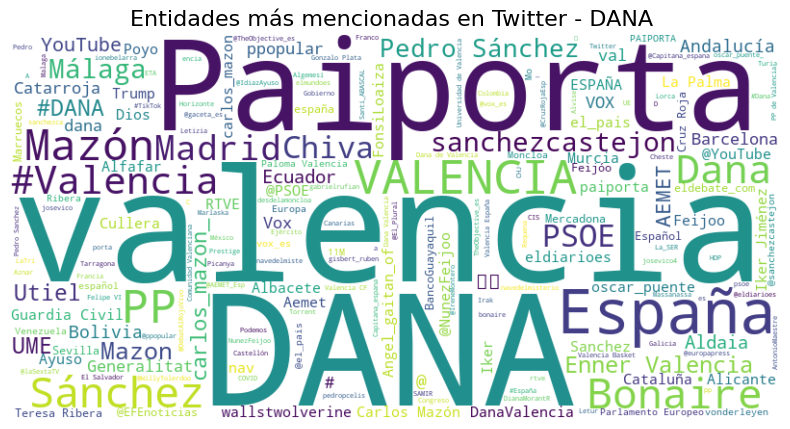

In [295]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all entities into a single list
punctuation_regex = r'^[\W_]+$'
all_entities = [
    entity['text'] 
    for entities in df['nlp_entities'] 
    if isinstance(entities, list)
    for entity in entities if entity['text'] not in ['.','Valencia'] 
]

# Create a word cloud for all entities
all_entities_counter = Counter(all_entities)
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(all_entities_counter)

# Plot the word cloud for all entities
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Entidades más mencionadas en Twitter - DANA ', fontsize=16)
plt.show()

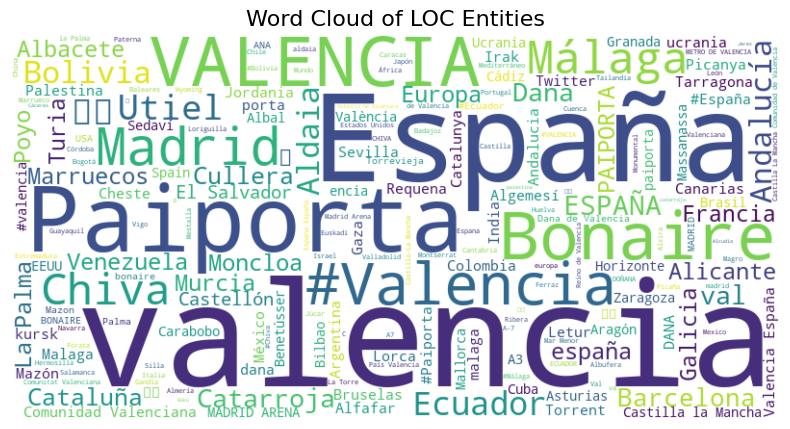

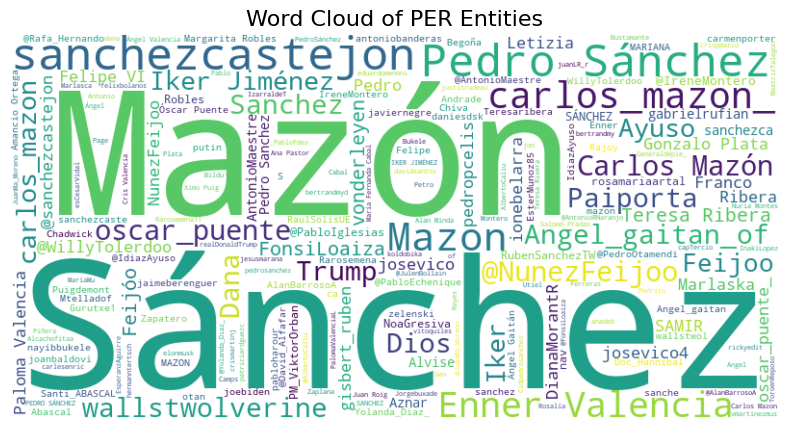

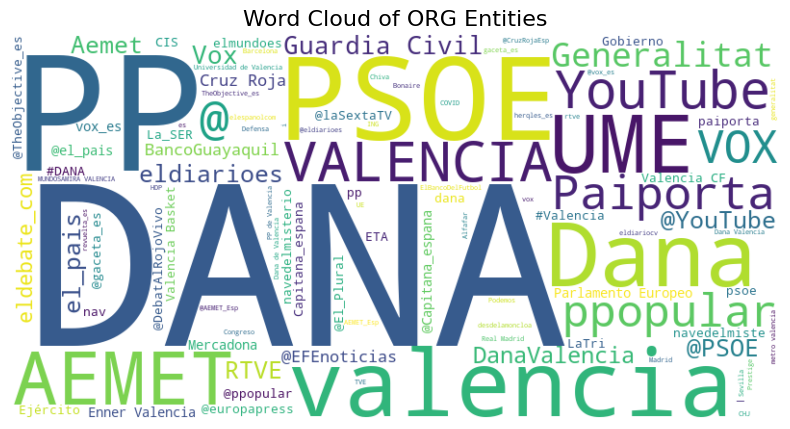

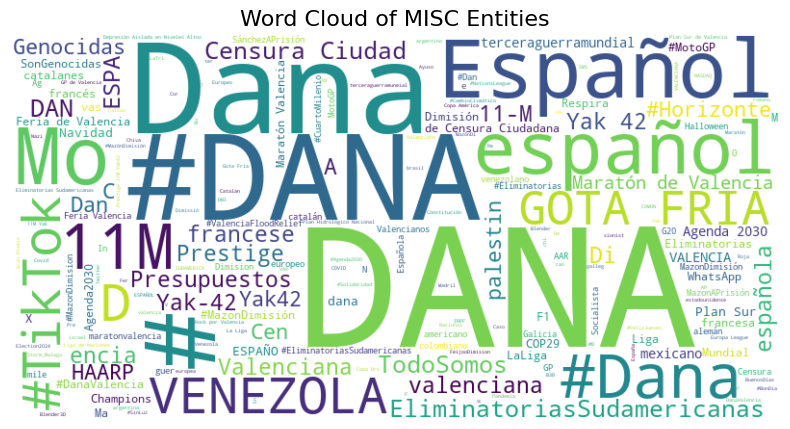

In [259]:
# Function to filter entities by type
def get_entities_by_label(entities_column, label):
    return [
        entity['text']
        for entities in entities_column
        if isinstance(entities, list)
        for entity in entities if entity['label'] == label and entity['text'] not in ['.','','Valencia'] 
    ]

# Create word clouds for each type of entity
entity_types = ['LOC', 'PER', 'ORG', 'MISC']
for entity_type in entity_types:
    # Get entities of the current type
    entities_of_type = get_entities_by_label(df['nlp_entities'], entity_type)
    entities_counter = Counter(entities_of_type)
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(entities_counter)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {entity_type} Entities', fontsize=16)
    plt.show()

In [260]:
# Plotting function

def plot_top_entities(entities, title, n=10, width=800, height=400):
    entity_counter = Counter(entities)
    top_entities = entity_counter.most_common(n)
    labels, counts = zip(*top_entities)

    fig = px.bar(
        x=counts,
        y=labels,
        orientation='h',
        title=title,
        labels={'x': 'Frequency', 'y': 'Entity'},
        template='plotly_white',
        width=width,
        height=height
    )
    fig.update_layout(yaxis={'categoryorder': 'total ascending'},
    title_font_size=20,         # Title font size
    xaxis_title_font_size=22,   # X-axis label font size
    yaxis_title_font_size=22,   # Y-axis label font size
    xaxis_tickfont_size=19,     # X-axis tick font size
    yaxis_tickfont_size=19      # Y-axis tick font size
)
    fig.show()


# Plot top N entities overall
plot_top_entities(all_entities, "Top Entities Overall", n=10,width=1000, height=600)

# Plot top N entities by type
entity_types = {'LOC':'location', 'PER':'person', 'ORG':'organization', 'MISC':'miscelaneous'}
for entity_type,format_name in entity_types.items():
    entities_by_type = get_entities_by_label(df['nlp_entities'], entity_type)
    plot_top_entities(entities_by_type, f"Most mentioned {format_name} Entities", n=15,width=1000, height=700)

In [338]:
# Function to extract entities and their sentiment
def get_entities_with_sentiment(entities_column, sentiment_column):
    entity_sentiment_pairs = []
    
    for entities, sentiment in zip(entities_column, sentiment_column):
        if isinstance(entities, list):
            for entity in entities:
                if entity['text'] not in ['.', '', 'Valencia']:  # Remove unnecessary terms
                    entity_sentiment_pairs.append((entity['text'], sentiment))  # Store (entity, sentiment)

    return entity_sentiment_pairs

# Extract entity-sentiment pairs
entity_sentiments = get_entities_with_sentiment(df['nlp_entities'], df['nlp_sentiment'])

# Count occurrences of each entity per sentiment
entity_counts = {}
for entity, sentiment in entity_sentiments:
    if entity not in entity_counts:
        entity_counts[entity] = {'POS': 0, 'NEU': 0, 'NEG': 0}
    
    entity_counts[entity][sentiment] += 1

# Convert dictionary to DataFrame
df_entity_counts = pd.DataFrame.from_dict(entity_counts, orient='index').reset_index()
df_entity_counts.rename(columns={'index': 'Entity', 'POS': 'Positive', 'NEU': 'Neutral', 'NEG': 'Negative'}, inplace=True)

# Keep only the most frequent entities (top 10 for visualization)
top_entities = df_entity_counts.set_index('Entity').sum(axis=1).nlargest(30).index
df_top_entities = df_entity_counts[df_entity_counts['Entity'].isin(top_entities)]

# Melt the DataFrame to long format for Plotly
df_top_entities_melted = df_top_entities.melt(id_vars='Entity', var_name='Sentiment', value_name='Number of mentions')

# Create the stacked bar plot using Plotly
fig = px.bar(
    df_top_entities_melted, 
    orientation='h',
    y='Entity', 
    x='Number of mentions', 
    color='Sentiment', 
    title='Most mentioned entities by sentiment',
    barmode='stack',
    color_discrete_map={'Positive': 'blue', 'Neutral': 'green', 'Negative': 'red'},
    width=1200, 
    height=900,
    template='plotly_white'
)

# Customize layout

fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                legend=dict(title='Sentiment',font=dict(size=18)),
                title_font_size=20,         # Title font size
                xaxis_title_font_size=22,   # X-axis label font size
                yaxis_title_font_size=22,   # Y-axis label font size
                xaxis_tickfont_size=19,     # X-axis tick font size
                yaxis_tickfont_size=19      # Y-axis tick font size
                )

fig.show()


In [292]:
# Function to extract entities and their sentiment
def get_entities_with_sentiment_type(entities_column, sentiment_column,ent_type):
    entity_sentiment_pairs = []
    
    for entities, sentiment in zip(entities_column, sentiment_column):
        if isinstance(entities, list):
            for entity in entities:
                if entity['text'] not in ['.', '', 'Valencia'] and entity['label'] == ent_type:  
                    entity_sentiment_pairs.append((entity['text'], sentiment))  # Store (entity, sentiment)

    return entity_sentiment_pairs


# Plot top N entities by type
entity_types = {'LOC':'locations', 'PER':'persons', 'ORG':'organizations', 'MISC':'miscelaneous'}
for entity_type,format_name in entity_types.items():

    # Extract entity-sentiment pairs
    entity_sentiments = get_entities_with_sentiment_type(df['nlp_entities'], df['nlp_sentiment'],entity_type)

    # Count occurrences of each entity per sentiment
    entity_counts = {}
    for entity, sentiment in entity_sentiments:
        if entity not in entity_counts:
            entity_counts[entity] = {'POS': 0, 'NEU': 0, 'NEG': 0}
        
        entity_counts[entity][sentiment] += 1

    # Convert dictionary to DataFrame
    df_entity_counts = pd.DataFrame.from_dict(entity_counts, orient='index').reset_index()
    df_entity_counts.rename(columns={'index': 'Entity', 'POS': 'Positive', 'NEU': 'Neutral', 'NEG': 'Negative'}, inplace=True)

    # Keep only the most frequent entities (top 10 for visualization)
    top_entities = df_entity_counts.set_index('Entity').sum(axis=1).nlargest(15).index
    df_top_entities = df_entity_counts[df_entity_counts['Entity'].isin(top_entities)]

    # Melt the DataFrame to long format for Plotly
    df_top_entities_melted = df_top_entities.melt(id_vars='Entity', var_name='Sentiment', value_name='Count')

    # Create the stacked bar plot using Plotly
    fig = px.bar(
        df_top_entities_melted, 
        orientation='h',
        y='Entity', 
        x='Count', 
        color='Sentiment', 
        title=f'Most mentioned {format_name} by sentiment',
        barmode='stack',
        color_discrete_map={'Positive': 'blue', 'Neutral': 'green', 'Negative': 'red'},
        width=1200, 
        height=700,
        template='plotly_white'
    )

    # Customize layout

    fig.update_layout(yaxis={'categoryorder': 'total ascending'},
                    legend=dict(title='Sentiment',font=dict(size=18)),
                    title_font_size=20,         # Title font size
                    xaxis_title_font_size=22,   # X-axis label font size
                    yaxis_title_font_size=22,   # Y-axis label font size
                    xaxis_tickfont_size=19,     # X-axis tick font size
                    yaxis_tickfont_size=19      # Y-axis tick font size
                    )

    fig.show()

In [50]:
pre_dana = df[(df['timestamp'] >= '2024-10-29 10:00:00') & (df['timestamp'] < '2024-10-29 18:00:00')]
pre_dana_count = len(pre_dana)
print(f"Número total de menciones pre-DANA: {pre_dana_count}")

Número total de menciones pre-DANA: 4305


In [ ]:
textos_pico_4 = df[(df['timestamp'] >= '2024-10-29 10:45:00') & (df['timestamp'] < '2024-10-29 11:00:00')]['text'].tolist()
fechas_pico_4 = df[(df['timestamp'] >= '2024-10-29 10:45:00') & (df['timestamp'] < '2024-10-29 11:00:00')]['timestamp'].tolist()
for texto,fecha in zip(textos_pico_4, fechas_pico_4):
    print(f'{texto} - {fecha}')

In [ ]:
textos_pico_4 = df[(df['timestamp'] >= '2024-10-29 10:40:00') & (df['timestamp'] < '2024-10-29 11:00:00')]['text'].tolist()
fechas_pico_4 = df[(df['timestamp'] >= '2024-10-29 10:40:00') & (df['timestamp'] < '2024-10-29 11:00:00')]['timestamp'].tolist()
for texto,fecha in zip(textos_pico_4, fechas_pico_4):
    print(f'{texto} - {fecha}')

In [220]:
dana_messages = df[(df['timestamp'] >= '2024-10-29 18:00:00') & (df['timestamp'] < '2024-10-30 00:00:00')]
dana_message_count = len(dana_messages)
print(f"Número total de mensajes DANA: {dana_message_count}")

Número total de mensajes DANA: 11856


In [240]:
post_dana = df[df['timestamp'] >= '2024-10-30 09:00:00']
post_dana_count = len(post_dana)
print(f"Número total de menciones post-DANA: {post_dana_count}")

Número total de menciones post-DANA: 139872


In [381]:
# Lista de palabras clave relacionadas con la Rambla del Poyo
keywords = [
    "Rambla", "Poyo", "barranco", "inundación",
    "caudal", "desbordamiento","agua"
]

# Crear un patrón de búsqueda con regex
keyword_pattern = "|".join(keywords)

# Filtrar mensajes que mencionen las palabras clave
df['relevant'] = df['text'].str.contains(keyword_pattern, case=False, na=False)
filtered_df = df[df['relevant']].copy()

start_date = "2024-10-29 10:00:00"
end_date = "2024-10-31 00:00:00"

# Filter rows in the range
filtered_df = filtered_df[(filtered_df['timestamp'] >= start_date) & (filtered_df['timestamp'] <= end_date)]
len(filtered_df)

1646

In [382]:
time_hourly_index = pd.date_range(start=filtered_df['time_hourly'].min(), end=filtered_df['time_hourly'].max(), freq='H')

# Agrupar por intervalos de tiempo (por hora, por día, etc.)
time_series = filtered_df.groupby('time_hourly').size().reindex(time_hourly_index, fill_value=0).reset_index(name='tweet_count')

time_series.columns = ['time', 'tweet_count']
print(time_series.head())

                 time  tweet_count
0 2024-10-29 10:00:00           21
1 2024-10-29 11:00:00           15
2 2024-10-29 12:00:00           19
3 2024-10-29 13:00:00            8
4 2024-10-29 14:00:00           14


In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords
import hdbscan

stop_words = stopwords.words("spanish")

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word != 'valencia'])  # Remove stopwords and "getxo"
    return text

# Define the time range
start_time = '2024-10-30 00:00:00'
#end_time = '2024-10-29 23:59:59'

# Filter messages within the time range
filtered_df = df[df['timestamp'] >= start_time]
print(len(filtered_df))

# Apply preprocessing
filtered_df['clean_text'] = filtered_df['text'].apply(preprocess_text)


# Customize the vectorizer with preprocessing
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
clusterer = hdbscan.HDBSCAN(min_cluster_size=100)
topic_model = BERTopic(language = 'multilingual', vectorizer_model = vectorizer_model, hdbscan_model=clusterer)


# Generate topics 
print("Generating topics...")
messages = filtered_df.clean_text.tolist()
topics_pos, probs_pos = topic_model.fit_transform(messages)
print("Topics:\n", topic_model.get_topic_info())



In [337]:
topics_df = topic_model.get_topic_info()
topics_df.head(30)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,62770,-1_dana_gente_si_paiporta,"[dana, gente, si, paiporta, españa, ayuda, gob...",[es igual con quién estaba mazón lo importante...
1,0,9790,0_paiporta_si_puta_chiva,"[paiporta, si, puta, chiva, mierda, barro, enn...",[hijo de puta has ido a hacerte la foto que to...
2,1,6710,1_valencià_españoles_país_valenciana,"[valencià, españoles, país, valenciana, españo...",[los de país valencià me tienen hasta los huev...
3,2,3416,2_manifestación_dimisión_izquierda_mazón,"[manifestación, dimisión, izquierda, mazón, ex...",[manifestación convocada por la sociedad civil...
4,3,2589,3_solidaridad_voluntarios_afectados_ayuda,"[solidaridad, voluntarios, afectados, ayuda, d...","[ayuda para los afectados en por dana, solidar..."
5,4,2161,4_inundaciones_riada_inundación_agua,"[inundaciones, riada, inundación, agua, río, p...","[inundación dana, inundaciones en, dana inunda..."
6,5,2078,5_gol_basket_fútbol_vs,"[gol, basket, fútbol, vs, liga, do, partido, e...","[tomamos gol do enner enner, gol do valência, ..."
7,6,1877,6_ejército_militares_militar_ejercito,"[ejército, militares, militar, ejercito, 500, ...","[y el ejército porque no está en ayudando, tod..."
8,7,1664,7_climático_cambio_clima_mata,"[climático, cambio, clima, mata, climática, co...",[que dice mi títere sánchez en la cop29 que la...
9,8,1585,8_millones_dinero_presupuestos_euros,"[millones, dinero, presupuestos, euros, ayudas...",[400 millones para los países más pobres 0 mil...


In [326]:
topic_model.visualize_barchart(n_words=10, top_n_topics=20, height = 300, title='Tópicos hablados durante la DANA en Twitter')

In [ ]:
topic_model.visualize_documents(messages)

In [ ]:
list_words_context = ['valencia', 'paiporta', 'massanasa', 'picaña', 'aldaia', 'bonaire', 'utiel', 'chiva']
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in list_words_context])  # Remove stopwords and "getxo"
    return text

# Apply preprocessing
df['clean_text'] = df['text'].apply(preprocess_text)

# Customize the vectorizer with preprocessing
vectorizer_model = CountVectorizer(ngram_range=(1, 1), stop_words=stop_words)
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
topic_model = BERTopic(language = 'multilingual', vectorizer_model = vectorizer_model, hdbscan_model=clusterer)


# Generate topics 
print("Generating positive topics...")
pos_messages = df['clean_text'][df['nlp_sentiment'] == 'POS'].tolist()
topics_pos, probs_pos = topic_model.fit_transform(pos_messages)
print("Topics:\n", topic_model.get_topic_info())

topic_model.visualize_barchart(n_words=10, top_n_topics=20, title='Tópicos positivos')

In [ ]:
topic_model = BERTopic(language = 'multilingual', vectorizer_model = vectorizer_model, hdbscan_model=clusterer)

# Generate topics 
print("Generating negative topics...")
neg_messages = df['clean_text'][df['nlp_sentiment'] == 'NEG'].tolist()
topics_pos, probs_pos = topic_model.fit_transform(neg_messages)
print("Topics:\n", topic_model.get_topic_info())

topic_model.visualize_barchart(n_words=7, top_n_topics=12, title='Tópicos negativos')

In [408]:
# Flatten the list of hashtags
all_hashtags = [hashtag for hashtags in df['hashtags'] for hashtag in hashtags]

# Count the occurrences of each hashtag
hashtag_counts = Counter(all_hashtags)

# Convert to a DataFrame for plotting
hashtag_df = pd.DataFrame(hashtag_counts.items(), columns=["hashtag", "count"]).sort_values(by="count", ascending=False)

print(hashtag_df)

                       hashtag  count
0                     Valencia   3113
4                         DANA   1378
30                        Dana    643
93                        dana    634
35                    valencia    606
...                        ...    ...
2478  EspecialRedacciónaDebate      1
2479                   LaCaixa      1
2480                   sánchez      1
2481               PromociónXL      1
5772               gmsviajes75      1

[5773 rows x 2 columns]


In [412]:
import plotly.express as px

# Plot the top N hashtags
top_n = 20  # Adjust as needed
fig = px.bar(
    hashtag_df.head(top_n),
    x="hashtag",
    y="count",
    title="Top Hashtags",
    labels={"hashtag": "Hashtag", "count": "Occurrences"},
    text="count"
)

# Customize layout
fig.update_traces(textposition='outside')
fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(title="Hashtags"),
    yaxis=dict(title="Number of Occurrences"),
    margin=dict(t=50, b=50, l=50, r=50)
)

fig.show()

In [427]:

# Safely flatten the entities while handling empty or invalid entries
all_entities = [
    (entity["text"], entity["label"])
    for entities in df["nlp_entities"]
    if isinstance(entities, list)  # Check if it's a valid list
    for entity in entities
]

# Count the occurrences of each entity
entity_counts = Counter(all_entities)

# Convert to a DataFrame for analysis
entity_df = pd.DataFrame(entity_counts.items(), columns=["entity", "count"]).sort_values(by="count", ascending=False)
entity_df[['text', 'label']] = pd.DataFrame(entity_df['entity'].tolist(), index=entity_df.index)
entity_df.drop(columns=['entity'], inplace=True)

# Número de entidades por tipo que quieres mostrar
top_k = 20

# Filtrar los top-k para cada tipo
top_entities = (
    entity_df.groupby('label')
    .apply(lambda group: group.nlargest(top_k, 'count'))
    .reset_index(drop=True)
)

# Generar gráficos separados por tipo de entidad
entity_types = top_entities['label'].unique()  # Obtener los tipos únicos de entidad

for entity_type in entity_types:
    # Filtrar por tipo de entidad
    filtered_df = top_entities[top_entities['label'] == entity_type]

    # Crear el gráfico
    fig = px.bar(
        filtered_df,
        x='text',
        y='count',
        title=f"Frecuencia de entidades ({entity_type}) en los tuits",
        labels={'text': 'Entidad', 'count': 'Frecuencia'},
        text='count'
    )

    # Personalizar el diseño
    fig.update_traces(textposition='outside')
    fig.update_layout(
        plot_bgcolor="white",
        margin=dict(t=50, b=50, l=50, r=50)
    )

    # Mostrar el gráfico
    fig.show()

/var/folders/wg/mqqjrx1572x668p69dq88t3r0000gn/T/ipykernel_45460/1983401826.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [320]:
# Count the occurrences of each sentiment
sentiment_counts = Counter(df['nlp_sentiment'][df['nlp_sentiment'].notnull()])

# Convert to a DataFrame for visualization
sentiment_df = pd.DataFrame(sentiment_counts.items(), columns=["sentiment", "count"]).sort_values(by="count", ascending=False)

# Rename sentiment labels
sentiment_df["sentiment"] = sentiment_df["sentiment"].replace({
    "POS": "Positive",
    "NEG": "Negative",
    "NEU": "Neutral"
})

# Define the correct sentiment order
sentiment_order = ["Positive", "Neutral", "Negative"]

# Create a pie chart
fig = px.pie(
    sentiment_df,
    names="sentiment",
    values="count",
    title="Distribution of Sentiment",
    color="sentiment",  # Map colors to sentiment types
    color_discrete_map={
        "Positive": "Blue",  
        "Negative": "Red",  
        "Neutral": "Green"   
    },
    category_orders={"sentiment": sentiment_order}
)


# Customize layout to position title on top and legend closer to the graph
fig.update_layout(
    font=dict(size=18),
    title=dict(
        text="Distribución de los sentimentos expresados",
        x=0.5,  # Center the title horizontally
        xanchor="center",
        yanchor="top",
        font=dict(size=22)  # Adjust font size if needed
    ),
    showlegend=True,
    legend_title="Sentiment",
    legend=dict(
        font=dict(size=18),
        x=0.65,  # Adjust horizontal position (closer to the right of the graph)
        y=0.9,  # Adjust vertical position (centered vertically)
        xanchor="left",
        yanchor="middle"
    ),
    margin=dict(t=100, b=50, l=50, r=100)  # Adjust margins for better spacing
)

fig.update_traces(textinfo="percent")  # Show percentage and label on the pie chart

fig.show()

In [312]:
# Flatten the list of emotions
all_emotions = [emotion for emotions in df["nlp_emotions"] if isinstance(emotions, list) for emotion in emotions]

# Count the occurrences of each emotion
emotion_counts = Counter(all_emotions)

# Convert to a DataFrame for visualization
emotion_df = pd.DataFrame(emotion_counts.items(), columns=["emotion", "count"]).sort_values(by="count", ascending=False)

# Rename sentiment labels
emotion_df["emotion"] = emotion_df["emotion"].str.capitalize()
# Plot the emotions as a bar chart
fig = px.bar(
    emotion_df,
    x="emotion",
    y="count",
    title="Emociones expresadas en los tuits",
    labels={"emotion": "Emoción", "count": "Frecuencia"},
    text="count",
    color="emotion",  # Optional: Color bars based on emotions
)

# Customize the layout
fig.update_traces(textposition="outside", showlegend=False)
fig.update_layout(
    plot_bgcolor="white",
    margin=dict(t=50, b=50, l=50, r=50)
)

fig.show()

In [321]:
# Create a pie chart
custom_colors = px.colors.qualitative.Pastel 

fig = px.pie(
    emotion_df,
    names="emotion",
    values="count",
    title="Emociones expresadas en los tuits",
    color="emotion",  # Optional: Color segments based on emotions
    color_discrete_sequence=custom_colors  # Custom color palette
)

# Customize layout
fig.update_traces(textinfo="percent")  # Show percentage and label

# Customize layout to position title on top and legend closer to the graph
fig.update_layout(
    font=dict(size=18),
    title=dict(
        text="Distribución de los sentimentos expresados",
        x=0.5,  # Center the title horizontally
        xanchor="center",
        yanchor="top",
        font=dict(size=22)  # Adjust font size if needed
    ),
    showlegend=True,
    legend_title="Emotion",
    legend=dict(
        font=dict(size=18),
        x=0.75,  # Adjust horizontal position (closer to the right of the graph)
        y=0.75,  # Adjust vertical position (centered vertically)
        xanchor="left",
        yanchor="middle"
    ),
    margin=dict(t=100, b=50, l=50, r=100)  # Adjust margins for better spacing
)

fig.update_traces(textinfo="percent")  # Show percentage and label on the pie chart

fig.show()

In [512]:

# Palabras clave asociadas con llamados a la acción
keywords = ["ayuda", "información", "apoyo", "solidaridad", "necesito", "urgente", "refugio"]

# Identificar mensajes relevantes
keyword_pattern = "|".join(keywords)
df["is_call_to_action"] = df["text"].str.contains(keyword_pattern, case=False, na=False)

# Calcular la proporción
total_messages = len(df)
call_to_action_messages = df["is_call_to_action"].sum()
proportion = call_to_action_messages / total_messages

print(f"Proporción de llamados a la acción: {proportion:.1%}")


Proporción de llamados a la acción: 13.1%


In [498]:
# Dictionary of aliases for political parties
party_aliases = {
    "PP": ["PP", "Partido Popular"],
    "PSOE": ["PSOE"],
    "Vox": ["Vox"],
    "Sumar": ["Unidas Podemos", "sumar"]
}

# Function to extract all mentions of parties in a text
def extract_party_mentions(text, aliases):
    matches = []
    for party, keywords in aliases.items():
        if any(keyword.lower() in text.lower() for keyword in keywords):
            matches.append(party)
    return matches

# Apply function to extract mentions and filter by negative sentiment
df["mentioned_parties"] = df.apply(
    lambda row: extract_party_mentions(row["text"], party_aliases) if row["nlp_sentiment"] == "NEG" else [],
    axis=1
)

# Flatten the list of mentions and count occurrences
all_mentions = [party for parties in df["mentioned_parties"] for party in parties]
mention_counts = Counter(all_mentions)

# Convert to DataFrame for visualization
mention_df = pd.DataFrame(mention_counts.items(), columns=["party", "count"]).sort_values(by="count", ascending=False)


# Gráfico de barras para menciones negativas por partido
fig = px.bar(
    mention_df,
    x="party",
    y="count",
    title="Menciones negativas de partidos políticos",
    labels={"party": "Partido", "count": "Cantidad de Menciones"},
    text="count",
    color="party"  # Colorear por partido
)

# Personalizar diseño
fig.update_traces(textposition="outside", showlegend=False)
fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(title="Partido"),
    yaxis=dict(title="Cantidad de Menciones"),
    margin=dict(t=50, b=50, l=50, r=50)
)

fig.show()

In [ ]:
# Initialize a dictionary to store topic models per party
topic_models = {}

# Perform topic modeling for each party
for party in df_exploded["mentioned_parties"].unique():
    print(f"\nTopic modeling for: {party}")
    
    # Filter messages mentioning the current party
    party_messages = df_exploded[df_exploded["mentioned_parties"] == party]["text"].tolist()
    
    # Initialize BERTopic
    topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, min_topic_size=20)  # Supports multiple languages, including Spanish
    
    # Fit the model
    topics, probs = topic_model.fit_transform(party_messages) 
    
    # Save the model for the party
    topic_models[party] = topic_model
    
    # Print the top topics
    print(topic_model.get_topic_info())

    # Optional: Visualize the topics
    fig = topic_model.visualize_barchart(top_n_topics=20, n_words=10, title=f"Top Topics for {party}")
    fig.show()